In [2]:
# Import libraries

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import pandas as pd
import numpy as np

import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

Using TensorFlow backend.


In [9]:
# Setup

EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 500
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 1000
MAX_NB_WORDS = 30000

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [133]:
# Get data from file

df = pd.read_csv("Complete_ds.csv")
df.describe()

Role                                            Content Subject  \
count      49353                                              49353   47403   
unique         7                                              46394   34356   
top     Employee  Alert! You are receiving this message because ...     RE:   
freq       18442                                                 31    1439   

                       Date                                       From  \
count                 49353                                      49353   
unique                46819                                       7895   
top     1980-01-01 00:00:00  frozenset({'arsystem@mailman.enron.com'})   
freq                     31                                        883   

                                            To  
count                                    49353  
unique                                    4774  
top     frozenset({'jeff.dasovich@enron.com'})  
freq                                      2401

In [134]:
df = df[["Role","Content"]]
class_size = df.groupby("Role").count().to_dict()
class_size

{'Content': {'CEO': 3039,
  'Director': 3360,
  'Employee': 18442,
  'Manager': 5590,
  'President': 5026,
  'Trader': 2460,
  'Vice President': 11436}}

In [135]:
# Create weight dictionary

class_weight = dict()
tot = 49353

for key,val in class_size["Content"].items():
    class_weight[key]= (1/val)*(tot/7)
    
class_weight

{'CEO': 2.3199830771400367,
 'Director': 2.098341836734694,
 'Employee': 0.38230281810153843,
 'Manager': 1.2612573473038589,
 'President': 1.4027912000454779,
 'Trader': 2.86602787456446,
 'Vice President': 0.6165117673512217}

In [9]:
# Basic data cleaning

msgList=list()
lines=df['Content'].values.tolist()
labels=df['Role'].values.tolist()
for line in lines:
    tokens=word_tokenize(line)
    tokens=[w.lower()for w in tokens]
    table=str.maketrans("","",string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    words=[word for word in stripped if word.isalpha()]
    stop_words=set(stopwords.words('english'))
    words=[w for w in words if not w in stop_words]
    msgList.append(words)
    
print(msgList[:3],labels[:3])

[['sue', 'landwehr', 'government', 'affairs', 'spoke', 'member', 'thompson', 'administration', 'indicated', 'governor', 'may', 'interested', 'talking', 'amtrak', 'specifically', 'ect', 'working', 'amtrak', 'quite', 'time', 'electricity'], ['spotlight', 'report', 'exchange', 'products', 'seeing', 'slow', 'trading', 'gavin', 'souter', 'business', 'insurance', 'page', 'copyright', 'c', 'crain', 'communications', 'inc', 'rights', 'reserved', 'exchangebased', 'insurance', 'products', 'developed', 'recent', 'years', 'somewhat', 'slow', 'get', 'ground', 'although', 'several', 'exchanges', 'offered', 'derivative', 'contracts', 'since', 'cover', 'insurance', 'risks', 'none', 'far', 'posted', 'significant', 'volume', 'trades', 'insurers', 'reinsurers', 'policyholders', 'drawn', 'away', 'traditional', 'insurance', 'markets', 'capacity', 'remains', 'abundant', 'relatively', 'cheap', 'long', 'traditional', 'markets', 'manage', 'weather', 'major', 'natural', 'catastrophes', 'allure', 'exchangebased'

In [10]:
# Convert to root words and track word positions

nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

msgListRootform = []
wordPositionList = []
for msg in msgList:
    rootMsg = []
    msgPos = []
    for word in msg:
        pos = get_wordnet_pos(word)
        msgPos.append(pos)
        rootMsg.append(lemmatizer.lemmatize(word, pos))
    
    msgListRootform.append(rootMsg)
    wordPositionList.append(msgPos)

print(msgListRootform[0],wordPositionList[0])

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


['sue', 'landwehr', 'government', 'affair', 'spoke', 'member', 'thompson', 'administration', 'indicate', 'governor', 'may', 'interested', 'talk', 'amtrak', 'specifically', 'ect', 'work', 'amtrak', 'quite', 'time', 'electricity'] ['n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'v', 'n', 'n', 'a', 'v', 'n', 'r', 'n', 'v', 'n', 'r', 'n', 'n']


In [11]:
msglist = list()
for msg in msgListRootform:
    txt = ""
    for word in msg:
        txt += word + " "
    msglist.append(txt)

poslist = list()
for msg in wordPositionList:
    txt = ""
    for word in msg:
        txt += word + " "
    poslist.append(txt)

    
dataList = []
dataList.append(labels)
dataList.append(msglist)
dataList.append(poslist)

data_df = pd.DataFrame(dataList)
data_df

0      \
0                                                CEO   
1  sue landwehr government affair spoke member th...   
2         n n n n n n n n v n n a v n r n v n r n n    

                                               1      \
0                                            Manager   
1  spotlight report exchange product see slow tra...   
2  n n n n v v n n n n n n n n n n n n v v n n n ...   

                      2      \
0                   Manager   
1  mccormack article group    
2                    n n n    

                                               3      \
0                                                CEO   
1  sue landwehr government affair spoke member th...   
2         n n n n n n n n v n n a v n r n v n r n n    

                                               4      \
0                                     Vice President   
1  december activity report weight average price ...   
2  n n v v a n n n n v n n n v n a n n n n v v a ...   

                                               5      \
0                                            Manager   
1  spotlight report exchange product see slow tra...   
2  n n n n v v n n n n n n n n n n n n v v n n n ...   

                                               6      \
0                                           Employee   
1  transwestern average delivery california mmbtu...   
2  n a n n n n n a n n n n n a n n v n n n n n n ...   

                      7      \
0                   Manager   
1  mccormack article group    
2                    n n n    

                                               8      \
0                                            Manager   
1  rick would difficult use option approach direc...   
2  n n a n n n r n a n n a n n n n n a n n n n n ...   

                                               9      ...  \
0                                                CEO  ...   
1  john talk david port tuesday regard var issue ...  ...   
2                                 n v n n n v n n n   ...   

                                               49343  \
0                                     Vice President   
1  award congratulation database select name one ...   
2  n n n v n n a n n n n a n v n n r r a n n n n ...   

                                               49344  \
0                                     Vice President   
1  hotwebcash iwon web portal like yahoo give awa...   
2  n n n n n n v r n n n n n a v n n n n n n n n ...   

                                               49345  \
0                                     Vice President   
1  hotwebcash complete short survey automatically...   
2  n a a n r v n a n n v r n n n v n n n n n n n ...   

                                               49346  \
0                                     Vice President   
1  hotwebcash program tailor specific need eat fo...   
2  n n v a n n n n a n n v n n n n n n r n n n n ...   

                                               49347  \
0                                     Vice President   
1  hotwebcash complete short survey automatically...   
2  n a a n r v n a n n v r n n n v n n n n n n n ...   

                                               49348  \
0                                     Vice President   
1  hotwebcash saw online movie thought right away...   
2  n n n n n n r n n n n v r v n n n n v v n n n ...   

                                               49349  \
0                                     Vice President   
1  hotwebcash part time help need work home earn ...   
2  n n n n v n n n n n a n n n n n n n n n n n v ...   

                                               49350  \
0                                     Vice President   
1  sincerely new offer staff email sent hotwebcas...   
2  r a n n n n n n n r n n n n a n n n n n n v n ...   

                                               49351  \
0                                     Vice President   
1  see message email client support html please c...   
2   v n n

In [12]:
data_df = data_df.T
data_df = data_df.rename(columns={0: "role", 1: "msg", 2:"tag"})
data_df.to_csv("datasetRootform.csv", encoding='utf-8', index=False)

# Run from here

In [3]:
df = pd.read_csv("datasetRootform.csv")
df.describe()

role                                                msg    tag
count      49353                                              49240  49240
unique         7                                              44702  40606
top     Employee  warn sent automatically inform mailbox approac...   n n 
freq       18442                                                178    225

In [4]:
lines=df['msg'].values.tolist()
labels=df['role'].values.tolist()
review_lines = list()
for line in lines:
    review_lines.append(str(line).split())
review_lines[0]

['sue',
 'landwehr',
 'government',
 'affair',
 'spoke',
 'member',
 'thompson',
 'administration',
 'indicate',
 'governor',
 'may',
 'interested',
 'talk',
 'amtrak',
 'specifically',
 'ect',
 'work',
 'amtrak',
 'quite',
 'time',
 'electricity']

In [5]:
# import gensim

# model=gensim.models.Word2Vec(sentences=review_lines,size=EMBEDDING_DIM,window=5,workers=4,min_count=1)
# words=list(model.wv.vocab)
# model.wv.save_word2vec_format("msg_embedding_word2vec.txt",binary=False)
# print(len(words))

In [6]:
import os
embeddings_index={}
f=open(os.path.join('','msg_embedding_word2vec.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close


<function TextIOWrapper.close()>

In [7]:
labelInt = {'CEO': 0,
 'Director': 1,
 'Employee': 2,
 'Manager': 3,
 'President': 4,
 'Trader': 5,
 'Vice President': 6}

labelsInt = list()
for txt in labels:
    labelsInt.append(labelInt[txt])
labelsInt[:6]

[0, 3, 3, 0, 6, 3]

In [10]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences=tokenizer_obj.texts_to_sequences(review_lines)

word_index=tokenizer_obj.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(len(data))
print(data[1])

encodeLabels = to_categorical(np.asarray(labelsInt))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', encodeLabels.shape)

49353
[  131   968  1980   219 19509 46385    15   934   106 29064    26   450
    60    45    31   218  1067    21  5878 18750    34  1595 11809 10129
   800   395  4534    26  2950  1150    21    45 10565   941 15994  1150
   147    26  1961   346 16453   772  1563   727  2561   455  9409   468
  9294  3187   295 12483   156    16   341  2798    21  1286   164    72
   162    66    26   633  1971 15994    34  1805  1144 35088   337  1484
  1086   206  1762  4432  1258   551   968   131  1183  1138  2518   395
 16453    26   319   103    55   199  3120  4535  1065  7088 16452   450
  1261  2617    16   231  1867    26   455  9409    83   485  6813   740
   450  9294   147 29065    55   179  2142    78    48   112    48   458
   568   851 29066 15994  1067   147 10129   159   161  1002   407   161
   325   103   159  2682  2617   221   159  2950  2798    21  8221    31
    50   960 10129  1216    26  9295 25065  1010  1045 20363   161   159
 10129   159   161   217 20363   632    48   

## Try with ANN

In [11]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [12]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      f1_score
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.MeanSquaredError(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________


In [13]:
# train model
history = model.fit(data, encodeLabels, epochs=20, validation_split=0.4, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Epoch 1/20
926/926 [==============================] - 6s 6ms/step - loss: 11.9743 - accuracy: 0.4310 - precision: 0.4202 - recall: 0.0209 - auc: 0.7558 - f1_score: 0.0211 - val_loss: 9.5524 - val_accuracy: 0.2872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6746 - val_f1_score: 0.0000e+00
Epoch 2/20
926/926 [==============================] - 5s 6ms/step - loss: 9.5514 - accuracy: 0.4313 - precision: 0.4583 - recall: 0.0111 - auc: 0.7573 - f1_score: 0.0113 - val_loss: 9.4671 - val_accuracy: 0.2872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6683 - val_f1_score: 0.0000e+00
Epoch 3/20
926/926 [==============================] - 6s 6ms/step - loss: 9.5324 - accuracy: 0.4313 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7570 - f1_score: 0.0000e+00 - val_loss: 9.6148 - val_accuracy: 0.2872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6724 - val_f1_score: 0.0000e+00
Epoch 4/20
926/926 [==============================] - 6s 

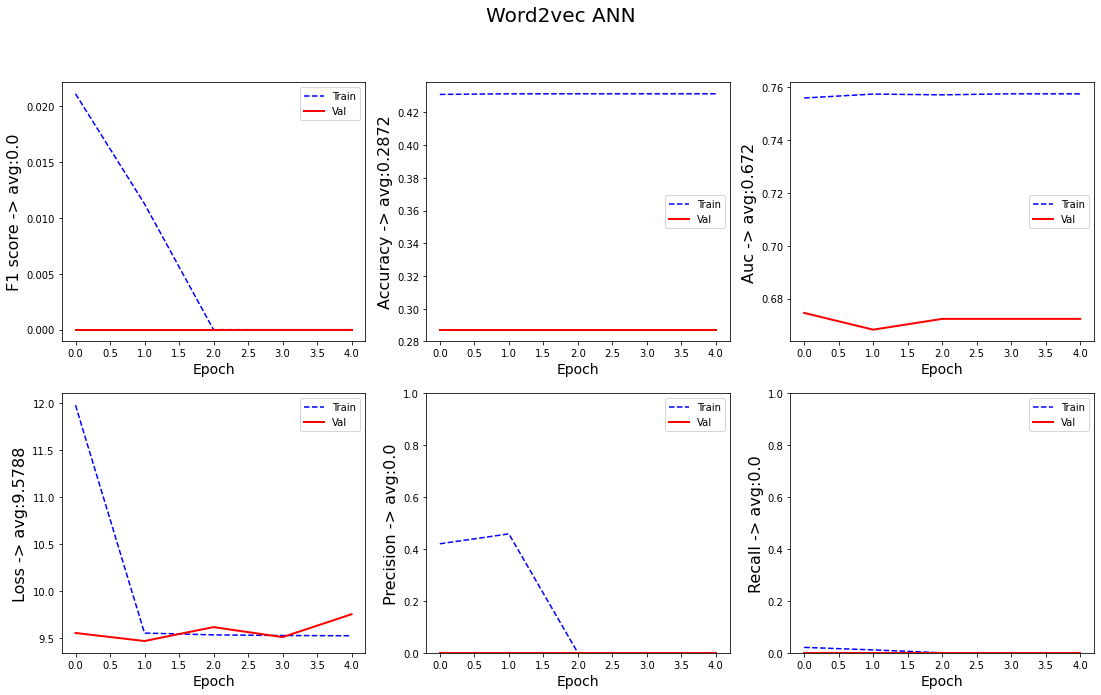

In [14]:
figName = "Word2vec ANN"

metrics =  ['f1_score', 'accuracy','auc', 'loss', 'precision', 'recall']
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    avg = sum(history.history['val_'+metric])/len(history.history[metric])
    plt.ylabel(name+" -> avg:"+str(round(avg,4)), fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')

## Try ANN with weight

In [9]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.3199830771400367,
 1: 2.098341836734694,
 2: 0.38230281810153843,
 3: 1.2612573473038589,
 4: 1.4027912000454779,
 5: 2.86602787456446,
 6: 0.6165117673512217}

In [10]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [17]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________


In [18]:
# train model
history = model.fit(data, encodeLabels, epochs=20, class_weight=class_weights, validation_split=0.4, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 29611 samples, validate on 19742 samples
Epoch 1/20
29611/29611 [==============================] - 11s 370us/sample - loss: 10.2650 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 177666.0000 - fn: 29611.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6614 - val_loss: 10.1352 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 118452.0000 - val_fn: 19742.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5198
Epoch 2/20
29611/29611 [==============================] - 7s 237us/sample - loss: 9.9316 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 177666.0000 - fn: 29611.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6612 - val_loss: 10.3202 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 118452.0000 - val_fn: 19742.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5207
Epoch 3/20
29611/29611 [====

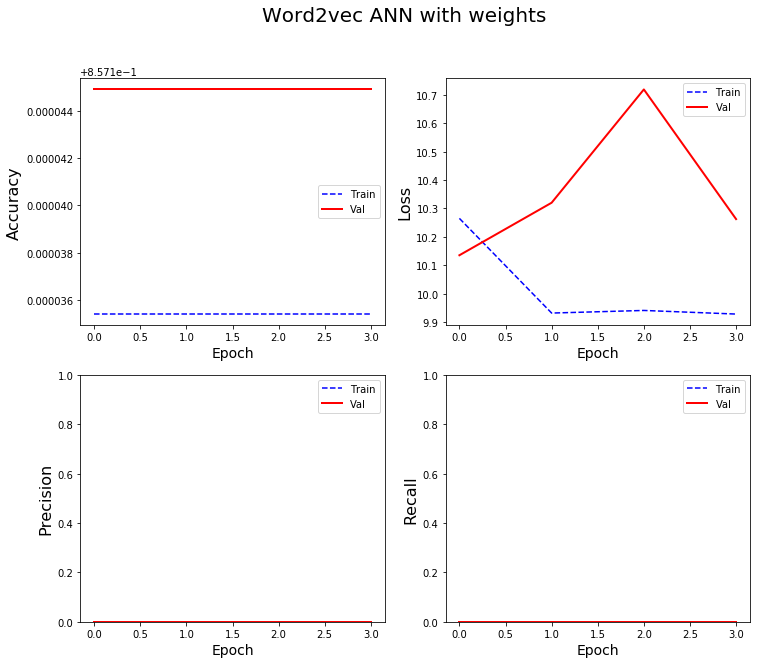

In [19]:
figName = "Word2vec ANN with weights"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')